In [1]:
%matplotlib inline

In [2]:
import numpy
import warnings
import ctypes
import scipy.constants as FCNST
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize, SymLogNorm

import healpy as hp

import bifrost
from bifrost.fft import Fft
from bifrost.ring import Ring
from bifrost.romein import Romein
from bifrost.unpack import unpack as Unpack

from bifrost.ndarray import memset_array, copy_array
from bifrost.device import set_device as BFSetGPU, get_device as BFGetGPU, set_devices_no_spin_cpu as BFNoSpinZone

from lsl.common.stations import lwasv

from astropy import units
from astropy.time import Time
import astropy_healpix as ahp
from astropy_healpix import HEALPix
from astropy.constants import c as speed_of_light
from astropy.coordinates import EarthLocation, TETE, SkyCoord, AltAz, Galactic

from pygdsm import GlobalSkyModel
import pyradiosky

In [3]:
def GenerateLocations(
    lsl_locs, frequencies, ntime, nchan, npol, grid_size=64, grid_resolution=20 / 60.
):
    delta = (2 * grid_size * numpy.sin(numpy.pi * grid_resolution / 360)) ** -1
    chan_wavelengths = speed_of_light.value / frequencies
    sample_grid = chan_wavelengths * delta
    sll = sample_grid[0] / chan_wavelengths[0]
    lsl_locs = lsl_locs.T
    lsl_locsf = lsl_locs[:, numpy.newaxis, numpy.newaxis, :] / sample_grid[numpy.newaxis, numpy.newaxis, :, numpy.newaxis]
    lsl_locsf -= numpy.min(lsl_locsf, axis=3, keepdims=True)

    # Centre locations slightly
    lsl_locsf += (grid_size - numpy.max(lsl_locsf, axis=3, keepdims=True)) / 2.

    # add ntime axis
    locc = numpy.broadcast_to(lsl_locsf, (ntime_gulp, 3, npol, nchan, lsl_locs.shape[1],)).transpose(1, 0, 3, 4, 2)
    return delta, locc, sll
#     np = numpy
#     delta = (2 * grid_size * np.sin(np.pi * grid_resolution / 360)) ** -1
#     chan_wavelengths = speed_of_light.value / frequencies
#     sample_grid = chan_wavelengths * delta
#     sll = sample_grid[0] / chan_wavelengths[0]
#     lsl_locs = lsl_locs.T
#     lsl_locs = lsl_locs.copy()

#     lsl_locsf = np.zeros(shape=(3, npol, nchan, lsl_locs.shape[1]))
#     for l in np.arange(3):
#         for i in np.arange(nchan):
#             lsl_locsf[l, :, i, :] = lsl_locs[l, :] / sample_grid[i]

#             # I'm sure there's a more numpy way of doing this.
#             for p in np.arange(npol):
#                 lsl_locsf[l, p, i, :] -= np.min(lsl_locsf[l, p, i, :])

#     # Centre locations slightly
#     for l in np.arange(3):
#         for i in np.arange(nchan):
#             for p in np.arange(npol):
#                 lsl_locsf[l, p, i, :] += (
#                     grid_size - np.max(lsl_locsf[l, p, i, :])
#                 ) / 2

#     # Tile them for ntime...
#     locx = np.tile(lsl_locsf[0, ...], (ntime, 1, 1, 1))
#     locy = np.tile(lsl_locsf[1, ...], (ntime, 1, 1, 1))
#     locz = np.tile(lsl_locsf[2, ...], (ntime, 1, 1, 1))
#     # .. and then stick them all into one large array
#     locc = np.concatenate([[locx, ], [locy, ], [locz, ]]).transpose(0, 1, 3, 4, 2).copy()

#     return delta, locc, sll


In [4]:
def make_lm_matrix(skymodes1d):
    lm_step = 2.0 / skymodes1d 
    i, j = numpy.meshgrid(numpy.linspace(-1, 1, skymodes1d, endpoint=False), numpy.linspace(-1, 1, skymodes1d, endpoint=False))
#     lm_matrix = numpy.asarray([i * lm_step - 1.0, j * lm_step - 1.0, numpy.zeros_like(j)])
    lm_matrix = numpy.asarray([i, j , numpy.zeros_like(j)])
    lm_matrix = numpy.fft.fftshift(lm_matrix, axes=(1, 2))
    lm_vector = lm_matrix.transpose([1, 2, 0 ])
    lm_vector[..., 2] = numpy.sqrt(1 - lm_vector[..., 0] ** 2 - lm_vector[..., 1] ** 2)
    return lm_vector


In [5]:
def get_phases(lwasv, nchan, nstand, npol):
    phases = numpy.zeros((nchan, nstand, npol), dtype=numpy.complex64)
    bad_ants = []
    for i in range(nstand):
        # X
        a = lwasv.antennas[2 * i + 0]
        delay = a.cable.delay(freq) - a.stand.z / speed_of_light.value
        phases[:, i, 0] = numpy.exp(2j * numpy.pi * freq * delay)
        phases[:, i, 0] /= numpy.sqrt(a.cable.gain(freq))
        if npol == 2:
            # Y
            a = lwasv.antennas[2 * i + 1]
            delay = a.cable.delay(freq) - a.stand.z / speed_of_light.value
            phases[:, i, 1] = numpy.exp(2j * numpy.pi * freq * delay)
            phases[:, i, 1] /= numpy.sqrt(a.cable.gain(freq))
        if lwasv.antennas[2 * i + 0].combined_status < 33 or lwasv.antennas[2 * i + 1].combined_status < 33:
            bad_ants.append(i)
#     phases = phases.conj()
    return phases, bad_ants

In [476]:
# EPICal object
class EPICal:
    """A Calibration Class for EPIC


    Parameters
    ----------
    antenna_locations : array
        A numpy array of antenna locations in units of wavelengths.
        Expected shape (nstand, nchan, npol, 3).
    cal_source_flux : array_like
        An array like of the flux in Jy for each source.
        Expected shape (n_sources, nchan, npol)
    cal_source_locs : array
        A nump array of the (l, m, n) or (l,m ) coordinates for each calibration source.
        Expected shape (n_sources, 2) or (n_sources, 3)
    lm_grid : array
        The (l, m) grid points of the image
        Expected shape (n_pixel, n_pixels, 2) or (n_pixel, n_pixel, 3)
    current_gains : array
        An array of current gains applied to the voltage stream.
        Expected shape (nstand, nchan, npol). Optional, defaults to ones.
    flagged_antennas : array
        An array of integers of the antennas indices corresponding to flagged antennas. Optional
    n_iter : int
        Number of iterations of correlation updates before new gains are solved estimated.
    ref_ant : int 
        The reference antenna for calibration.
    inv_gains : bool
        When true, gains are assumed to be multiplicative.
    damping_factor : float
        The damping factor used when updating calibration solutions, must be in the range [0, 1]
    phase_fit : bool
        When True, only fits the phase of the calibration.
    
    """
    def __init__(
        self,
        antenna_locations,
        cal_source_flux,
        cal_source_locs,
        lm_grid,
        current_gains=None,
        flagged_antennas=None,
        n_iter=10,
        ref_ant=0,
        inv_gains=False,
        damping_factor=0,
        phase_fit=False,
        exclude_autos=False,
        fix_holographic_phase=True,
        flatten_array=False,
        conv_thresh=0.000001,
        conv_max_try=2000,
    ):

        self.nstand = antenna_locations.shape[0]
        self.nchan = antenna_locations.shape[1]
        self.npol = antenna_locations.shape[2]
        self.locations = antenna_locations
        
        self.good_ants = numpy.ones(shape=(self.nstand), dtype=numpy.bool)
        if flagged_antennas is not None:
            self.good_ants[flagged_antennas] = False
        
        self.cal_source_flux = cal_source_flux
        self.n_cal_sources = self.cal_source_flux.shape[0]
        self.linalg = bifrost.linalg.LinAlg()
        
        if cal_source_locs.shape[-1] == 2:
            tmp_locs = numpy.zeros((self.n_cal_sources, 3))
            tmp_locs[:, :2] = cal_source_locs
            tmp_locs[:, 2] = numpy.sqrt(1 - tmp_locs[:, 0] ** 2 - tmp_locs[:, 1] ** 2)
            cal_source_locs = tmp_locs

        self.cal_source_locs = cal_source_locs

        self.cal_pixel_inds = None
        self.cal_pixel_locs = None

        if lm_grid.shape[2] == 2:
            tmp_lm = numpy.zeros((lm_grid.shape[0], lm_grid.shape[1], 3))
            tmp_lm[:, :, :2] = lm_grid
            tmp_lm[:, :, 2] = numpy.sqrt(1 - tmp_lm[:, :, 0] ** 2 - tmp_lm[:, :, 1]**2)
            lm_grid = tmp_lm

        self.lm_grid = lm_grid

        if current_gains is None:
            current_gains = numpy.ones((self.nstand, self.nchan, self.npol), dtype=numpy.complex64)

        self.current_gains = numpy.asarray(current_gains)
        self.n_iter = n_iter
        self.calibration_loop_count = 0

        self.ref_ant = ref_ant
        self.inv_gains = inv_gains
        self.damping_factor = damping_factor
        self.phase_fit = phase_fit
#         self.auto_noise_model = auto_noise_model
        self.exclude_autos = exclude_autos
        self.fix_holographic_phase = fix_holographic_phase
        self.flatten_array = flatten_array
        self.conv_thresh = conv_thresh
        self.conv_max_try = conv_max_try
    
        self.auto_corr = bifrost.zeros((self.nstand, self.nchan, self.npol), dtype=numpy.complex64, space="cuda")
        self.ant_twt = numpy.zeros((self.nstand, self.nchan, self.npol), dtype=numpy.int32)
        
        self.cal_corr = bifrost.zeros(
            (self.nchan, self.npol, self.nstand, self.n_cal_sources),
            dtype=numpy.complex64,
            space="cuda"
        )

    def calculate_model_visibilities(self):
        self.cal_pixel_inds = numpy.ascontiguousarray(
            numpy.atleast_2d(
                numpy.asarray(
                    numpy.unravel_index(
                        numpy.argmin(
                            (self.lm_grid[:, :, 0].reshape(-1, 1) - self.cal_source_locs[numpy.newaxis, :, 0]) ** 2
                            + (self.lm_grid[:, :, 1].reshape(-1, 1) - self.cal_source_locs[numpy.newaxis, :, 1]) ** 2,
                            axis=0,
                        ),
                        self.lm_grid.shape[:2]
                    )
                ).T
            )
        )
        self.cal_pixel_inds = bifrost.ndarray(self.cal_pixel_inds).copy()

        self.cal_pixel_locs = self.lm_grid[self.cal_pixel_inds[:, 0], self.cal_pixel_inds[:, 1], :]

        self.model_vis = numpy.zeros((self.nstand, self.nstand, self.nchan, self.npol), dtype=numpy.complex64)
        uvws = self.locations[:, numpy.newaxis, :, :, :] - self.locations[numpy.newaxis, :, :, :, :]

        self.model_vis = numpy.sum(
            self.cal_source_flux[:, numpy.newaxis, numpy.newaxis, :, :]
            * numpy.exp(
                -1j * 2 * numpy.pi 
                * numpy.sum(
                    self.cal_source_locs[:, numpy.newaxis, numpy.newaxis, numpy.newaxis, numpy.newaxis, :]
                    * uvws[numpy.newaxis, :, : , :, :, :],
                    axis=-1,
                ),
            ),
            axis=0,
        ).astype(numpy.complex64)

        if self.exclude_autos:
            for ant in range(self.nstand):
                self.model_vis[ant, ant, :, :] = 0.0

        # Add phase to flatten array
        if self.flatten_array:
            print("Flattening")
            # TODO: check conjugation
            self.model_vis *= numpy.exp(
                1j * 2 * numpy.pi * uvws[..., 2]
            )
        return

    def calculate_correlation(self, voltage_stream, calibration_pixel_values):
        """
        
        Parameters
        -----------
        voltage_stream : array
            Array of the antenna voltage stream. Has shape (nchan, npol, nstand, ntimes)
            
        calibration_pixel_values : array
            Array of the e-field image values has shape (nchan, npol, ntimes, n_cal_sources)
        """
        ntimes = voltage_stream.shape[-1]
        
        bifrost.map(
            "for(auto l=0; l<{ntimes};l++){{a(i,j,k,m) += b(i,j,k,l) * c(i,j,l,m).conj();}}".format(ntimes=ntimes),
            data={"a":self.cal_corr, "b":voltage_stream, "c":calibration_pixel_values},
            axis_names=("i", "j", "k", "m"),
            shape=(self.nchan, self.npol, self.nstand, self.n_cal_sources)
        )
        
#         self.cal_corr = self.linalg.matmul(1.0, voltage_stream, calibration_pixel_values.copy(), 1, self.cal_corr)
        
        self.ant_twt += ntimes
        
        if self.exclude_autos:
            bifrost.map(
                "for(auto l=0; l<{ntimes}; l++) {{a(k,i,j) += b(i,j,k,l) * b(i,j,k,l).conj();}}".format(ntimes=ntimes),
                data={"a": self.auto_corr, "b": voltage_stream},
                axis_names=("i","j", "k"),
                shape=(self.nchan, self.npol, self.nstand),
            )

        self.calibration_loop_count += 1
        
    
    def copy_calibration_pixels(self, efield_cal_image):
        
        ntimes = efield_cal_image.shape[1]
        
        calibration_pixel_values =  bifrost.zeros(
            shape=(self.nchan, self.npol, ntimes, self.n_cal_sources),
            dtype=numpy.complex64,
            space="cuda",
        )

        bifrost.map(
            "a(j,k,l,i) = b(0,l,j,k,c(i,0),c(i,1))",
            data={"a": calibration_pixel_values, "b": efield_cal_image, "c": self.cal_pixel_inds.copy(space="cuda")},
            axis_names=("i", "j", "k", "l"),
            shape=(self.n_cal_sources, self.nchan, self.npol, ntimes),
        )
        
        return calibration_pixel_values

    def estimate_gains(self, input_voltage_stream, efield_image):
        """
        
        Parameters
        -----------
        voltage_stream : bifrost.ndarray
            Array of the antenna voltage stream has dtype ci4. Has shape (ntimes, nchan, nstand, npol)
            
        efield_image : bifrost
            Array of the e-field image has shape (ntime, nchan, npol, npixels, npixels)
        """
        
        if self.cal_pixel_inds is None:
            self.calculate_model_visibilities()
            
        calibration_pixel_values = self.copy_calibration_pixels(efield_image)
        
        input_voltage_stream = input_voltage_stream.transpose([1,3,2,0]).copy()
        input_voltage_stream = input_voltage_stream.copy(space="cuda")
        
        g_voltage_stream = bifrost.ndarray(shape=input_voltage_stream.shape, dtype=numpy.complex64, space="cuda")
        Unpack(input_voltage_stream, g_voltage_stream)
        
        self.calculate_correlation(g_voltage_stream, calibration_pixel_values)
        
        if self.calibration_loop_count == self.n_iter:
            
            tries = 0
            convergence_delta = 100.0
            temp_gains = numpy.broadcast_to(
                self.current_gains[numpy.newaxis], 
                (self.n_cal_sources, self.nstand, self.nchan, self.npol),
            ).copy()
            
            temp_gains[:, ~self.good_ants] = 0
           
#             phasor = temp_gains[:, self.ref_ant] / numpy.abs(temp_gains[:, self.ref_ant])
#             temp_gains *= numpy.conj(phasor)[:, numpy.newaxis]
            
            self.ant_twt[~self.good_ants] = 0
            self.cal_corr = numpy.asarray(
                self.cal_corr.copy(space="system").transpose([3, 2, 0, 1])
            ).copy()
            self.auto_corr = numpy.asarray(
                self.auto_corr.copy(space="system")
            ).copy()
            
            if self.fix_holographic_phase:
                # The holographic images have a silly phase running through them due to not centering when padding. Take it out.
                dl = self.lm_grid[0, 1, 0] - self.lm_grid[0, 0, 0]
                dm = self.lm_grid[1, 0, 1] - self.lm_grid[0, 0, 1]

                phase_fix = numpy.exp(
                    -1j * numpy.pi 
                    * (self.cal_pixel_locs[:,0] / dl + self.cal_pixel_locs[:,1] / dm) / 2
                )
                self.cal_corr *=  phase_fix[:, numpy.newaxis, numpy.newaxis, numpy.newaxis]   
            
            self.cal_corr /=  self.ant_twt[numpy.newaxis] # make it an average
            self.cal_corr[:, ~self.good_ants, :, :] = 0


            if self.inv_gains:
                # applying multiplicative gains, these get conjugated when applied
                applied_cal = numpy.asarray(self.current_gains[numpy.newaxis])
#                 applied_cal = numpy.asarray(self.current_gains.copy())
            else:
                applied_cal = 1./ self.current_gains[numpy.newaxis]
            
            applied_cal[:, ~self.good_ants] = 0
            
            if self.exclude_autos:
                self.auto_corr /= self.ant_twt
                self.auto_corr[~self.good_ants, ...] = 0
                
                print("autos are one:", numpy.allclose(self.auto_corr[self.good_ants], 1))

                b_dot_s_auto = numpy.exp(
                    -1j * 2 * numpy.pi
                    * numpy.sum(
                        self.locations[numpy.newaxis, :, :, :, :2] * self.cal_pixel_locs[:, numpy.newaxis, numpy.newaxis, numpy.newaxis, :2],
                        axis=4,
                    )
                )
                subtraction_factor = applied_cal.conj() * b_dot_s_auto * self.auto_corr[numpy.newaxis]  / self.nstand
                subtraction_factor[:, ~self.good_ants] = 0

                self.cal_corr -= subtraction_factor
            
            ant_index = numpy.arange(self.nstand)[self.good_ants][0]
            print("correlations same for each ant", numpy.allclose(self.cal_corr[:,self.good_ants], self.cal_corr[:,ant_index][:, numpy.newaxis]))

            assert numpy.nonzero(self.cal_corr[:, ~self.good_ants])[0].sum() == 0, f"bad ants not zero"

            b_dot_s = numpy.sum(
                # broadcast the antenna positions and cal_pix_locs up to (n_cal_sources, nstand, nstand, nchan, npol, 2) to match model visibilites
                self.locations[numpy.newaxis, numpy.newaxis, :, :, :, 0:2] 
                * self.cal_pixel_locs[:, numpy.newaxis, numpy.newaxis, numpy.newaxis, numpy.newaxis, 0:2],
                axis=5,
            )
            print("temp", "prev", "temp-prev", "abs(temp-prev)", "abs(prev)", "delta", "max detla index")
            while (tries < self.conv_max_try) and (convergence_delta > self.conv_thresh):

                prev_gains = temp_gains.copy()
                prev_gains[:, ~self.good_ants] = 0
                
                
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    
#                     gain_ratio = applied_cal.conj() / prev_gains.conj()
                    gain_ratio = applied_cal.conj() * prev_gains.conj()
#                     gain_ratio = applied_cal * prev_gains.conj()
#                     if self.inv_gains:
#                         gain_ratio = prev_gains / applied_cal 
#                     else:
#                         gain_ratio = prev_gains * applied_cal
                    gain_ratio[:, ~self.good_ants] = 0
#                     divisor = 
                    divisor = numpy.nansum(
#                         (self.nstand - 1)  # where does this come from?
                        1 * self.ant_twt[numpy.newaxis, numpy.newaxis]
                        * numpy.exp(-1j * 2 * numpy.pi *  b_dot_s) 
                        * self.model_vis[numpy.newaxis]  # add n_cal_sources axis
                        * gain_ratio[:, numpy.newaxis],  # add extra nstand axis
                        axis=2,
                    )
                    temp_gains = (
                        self.cal_corr 
                        * (self.ant_twt.sum(axis=0, keepdims=True) - self.ant_twt)[numpy.newaxis] # broadcast over the nsources dimension
                        * self.nstand 
                        / divisor
                    )
                    
                    phasor = temp_gains[:, self.ref_ant]  / numpy.abs(temp_gains[:, self.ref_ant])
                    temp_gains *= numpy.conj(phasor)[:, numpy.newaxis]
    
                    temp_gains[:, ~self.good_ants] = 0
                
                    temp_gains = prev_gains * self.damping_factor + temp_gains * (1 - self.damping_factor)
                
                    convergence_delta = numpy.ma.masked_array(numpy.abs(temp_gains - prev_gains))
                    convergence_delta.mask = numpy.zeros(convergence_delta.shape, dtype=numpy.bool_)
                    convergence_delta[:, ~self.good_ants] = True
                    convergence_delta /= numpy.abs(prev_gains)
                    convergence_delta.mask |= numpy.logical_not(numpy.isfinite(convergence_delta))
                    shape = convergence_delta.shape
                    argmax = numpy.ma.argmax(convergence_delta)
                    argmax = numpy.unravel_index(argmax, shape)
                    convergence_delta = numpy.ma.max(convergence_delta)

                    if tries % 100 == 0:
                        print(temp_gains[argmax], prev_gains[argmax], (temp_gains - prev_gains)[argmax], numpy.abs((temp_gains - prev_gains)[argmax]), numpy.abs(prev_gains)[argmax], end=" ")
                        print(convergence_delta, argmax)
                tries += 1

            if tries == self.conv_max_try:
                print(f"Maximum tries exceeded before convergence achieved. Final change: {convergence_delta}")
            else:
                print(f"Converged in {tries} iterations. Final change: {convergence_delta}")

            temp_gains = numpy.average(temp_gains, weights=numpy.ones_like(temp_gains), axis=0)
            temp_gains[~self.good_ants] = 0
            
            if self.phase_fit:
                # Only fit phase
                temp_gains /=  numpy.abs(self.current_gains)
#             print(self.cal_corr)

            print("percent nan", numpy.isnan(temp_gains).sum()/float(temp_gains.size))
            print("current amp", numpy.mean(numpy.abs(self.current_gains)))
            
            self.current_gains = numpy.where(
                numpy.isnan(temp_gains),
                self.current_gains,
                temp_gains,
#                 self.current_gains * self.damping_factor + temp_gains * (1 - self.damping_factor),
            )
            
            print("new amp", numpy.mean(numpy.abs(self.current_gains)))
            
            if self.phase_fit:
                self.current_gains /=  numpy.abs(self.current_gains)
            
#             self.current_gains[~self.good_ants] = 0
            self.temp_gains = temp_gains
            # reset the necessary paramters to start a new calibration loop
            self.calibration_loop_count = 0
#             self.auto_corr = bifrost.zeros((self.nstand, self.nchan, self.npol), dtype=numpy.complex64, space="cuda")
#             self.ant_twt = numpy.zeros((self.nstand, self.nchan, self.npol), dtype=numpy.int32)

#             self.cal_corr = bifrost.zeros(
#                 (self.nchan, self.npol, self.nstand, self.n_cal_sources),
#                 dtype=numpy.complex64,
#                 space="cuda"
#             )
        
    def get_gains(self):
        if self.inv_gains: 
            return self.current_gains.astype(numpy.complex64)
        return 1./self.current_gains.astype(numpy.complex64)

In [7]:
BFSetGPU(0)

In [8]:
voltage_file = "/data4/mkolopanis/src/LWA_EPIC/epic_data_voltages.npz"
efield_image = "/data4/mkolopanis/src/LWA_EPIC/epic_efield_image.npz"
ateam_file =  "/data3/MWA/MWA_simpleds/simulation/catalogs/rlb2019_ateam_sources_gleam.vot"

In [9]:
voltages = numpy.load(voltage_file, allow_pickle=True)

In [10]:
image = numpy.load(efield_image, allow_pickle=True)

In [11]:
voltage_hdr = voltages["hdr"].item()
img_hdr = image["hdr"].item()

In [12]:
voltages["hdr"], voltages["data"].shape

(array({'time_tag': 297616560436264860, 'seq0': 0, 'chan0': 1022, 'nchan': 4, 'cfreq': 25609999.98729676, 'bw': 100000.0, 'nstand': 256, 'npol': 2, 'nbit': 4, 'complex': True, 'axes': 'time,chan,stand,pol'},
       dtype=object),
 (512, 4, 256, 2))

In [13]:
image["hdr"], image["data"].shape

(array({'time_tag': 297616560436264860, 'seq0': 0, 'chan0': 1022, 'nchan': 4, 'cfreq': 25609999.98729676, 'bw': 100000.0, 'nstand': 256, 'npol': 4, 'nbit': 64, 'complex': True, 'axes': 'time,chan,pol,gridy,gridx', 'grid_size_x': 64, 'grid_size_y': 64, 'sampling_length_x': 0.49999887562843115, 'sampling_length_y': 0.49999887562843115, 'accumulation_time': 61.44, 'FS': 196000000.0, 'latitude': 34.348358, 'longitude': -106.885783, 'telescope': 'LWA-SV', 'data_units': 'UNCALIB', 'pols': ['xx', 'xy', 'yx', 'yy']},
       dtype=object),
 (1, 512, 4, 2, 64, 64))

In [14]:
site_loc = EarthLocation.from_geodetic(
    lwasv.lon * (180.0 / numpy.pi),
    lwasv.lat * (180.0 / numpy.pi),
    height=1511 * units.m,
)

In [15]:
lwasv_antennas = lwasv.antennas
obstime = Time(img_hdr["time_tag"] / img_hdr["FS"], format="unix", location=site_loc)
lon = img_hdr["longitude"] * units.deg
lat = img_hdr["latitude"] * units.deg
ntime_gulp = image["data"].shape[1]
chan_bw = img_hdr["bw"]
FS = 196.0e6
CHAN_BW = 25.0e3
chan0 = img_hdr["chan0"]
cfreq = img_hdr["cfreq"]
nchan = img_hdr["nchan"]
npol = voltage_hdr["npol"]
# npol = 1
grid_size = skymodes1d = 65
imageres = 1.79057
ant_extent = 1
# freq = (cfreq + numpy.arange(nchan) * chan_bw)
freq = (chan0 + numpy.arange(nchan)) * CHAN_BW
point_source=True
ones_test=False
use_skymod=False
n_source_gsm=75

In [16]:
locations = numpy.array([(ant.stand.x, ant.stand.y, ant.stand.z) for ant in lwasv.antennas[::2]])
locations[255, :] = 0.0
nstand = locations.shape[0]
sampling_length, locs, sll = GenerateLocations(locations, freq, ntime_gulp, nchan, npol, grid_size=grid_size, grid_resolution=imageres)

In [17]:
gpu_locs = bifrost.ndarray(locs.astype(numpy.int32).copy(), space="cuda")

phases, bad_ants = get_phases(lwasv, nchan, nstand, npol)
bad_ants.append(255)
bad_ants = numpy.asarray(bad_ants)
phases[:, bad_ants, :] =0
lm_matrix = make_lm_matrix(skymodes1d)
print(bad_ants)

[ 40  91 107 109 119 132 133 135 141 149 162 194 202 203 212 216 217 228
 255]


<ipython-input-4-855bbbf43b13>:8: RuntimeWarning: invalid value encountered in sqrt
  lm_vector[..., 2] = numpy.sqrt(1 - lm_vector[..., 0] ** 2 - lm_vector[..., 1] ** 2)


In [18]:
# phases *= numpy.conj(phases[:, 5, :] / numpy.abs(phases[:, 5, :]))[:, numpy.newaxis, :]

In [19]:
 numpy.asarray(2 * FCNST.Boltzmann * (FCNST.speed_of_light / freq)**2 * 10**26, dtype=numpy.float64)

array([380165.65156163, 379422.77796955, 378682.07970209, 377943.54827431])

In [375]:
if point_source:
    radec = numpy.array([[5.233686583, 0.71094094367], [6.12377129663, 1.02645722192]])
#     fluxes = src_flux = numpy.array([20539.0, 19328.0])
    fluxes = src_flux = numpy.array([7500.0, 8000.0])
#     fluxes[1] *= 0.57 # a fudging factor because it is down in the beam
#     radec = radec[0]
#     fluxes = fluxes[0] 
    fluxes = numpy.atleast_1d(fluxes)
    radec = numpy.atleast_2d(radec)
    sou_info = SkyCoord(
        ra=radec[:, 0] * units.rad, dec=radec[:, 1] * units.rad, frame="icrs",
    )
elif use_skymod:
    ateam = pyradiosky.SkyModel()
    ateam.read_gleam_catalog(ateam_file, spectral_type="spectral_index")
    ateam.at_frequencies(freq * units.Hz)
    ateam.update_positions(obstime, site_loc)
    sou_info = SkyCoord(
        ra=ateam.ra, dec=ateam.dec, frame="icrs",
    )
    fluxes = ateam.stokes[0].transpose([1,0])
else:
    
  
    gsm2008 = GlobalSkyModel(freq_unit="Hz")
    fluxes = gsm2008.generate(freq)
    fluxes = hp.pixelfunc.ud_grade(fluxes, 16)
    gsm2008_coords = HEALPix(ahp.npix_to_nside(fluxes.shape[1]), frame=Galactic())
    sou_info = gsm2008_coords.healpix_to_skycoord(numpy.arange(gsm2008_coords.npix))
    sou_info = sou_info.transform_to("icrs")
    
    fluxes *= numpy.asarray(2 * FCNST.Boltzmann * (FCNST.speed_of_light / freq)**2 * 10**26, dtype=numpy.float64)[:, numpy.newaxis] # Jy/str


app_coord_data = sou_info.transform_to(
    TETE(location=site_loc, obstime=obstime)
)

In [376]:
fluxes.shape

(2,)

In [377]:
app_coord_data.ra, obstime.sidereal_time("apparent").deg, site_loc.lat.rad

(<Longitude [300.01716468, 351.06347381] deg>,
 278.4353232431326,
 0.5994919397537344)

In [378]:
numpy.cos(app_coord_data.altaz.zen.rad) ** 1.6

array([0.92101211, 0.45401003])

In [379]:
# lm_coords = numpy.sin(app_coord_data.altaz.zen).reshape(-1, 1)* numpy.asarray([numpy.cos(app_coord_data.altaz.az.rad), numpy.sin(app_coord_data.altaz.az.rad)]).T
lm_coords = numpy.sin(app_coord_data.altaz.zen).reshape(-1, 1)* numpy.asarray([numpy.cos(numpy.pi /2 - app_coord_data.altaz.az.rad), numpy.sin(numpy.pi/2 - app_coord_data.altaz.az.rad)]).T
good_pix = app_coord_data.altaz.zen.deg <= 90   
lm_coords = lm_coords[good_pix]
# lm_coords = skypos[:,:2]

if point_source: 
    fluxes *= numpy.cos(app_coord_data.altaz.zen.rad) ** 1.6
    cal_source_flux = numpy.broadcast_to(fluxes[:, numpy.newaxis, numpy.newaxis], (fluxes.shape[0], nchan, npol))
elif use_skymod:
    cal_source_flux = numpy.broadcast_to(fluxes[:, :, numpy.newaxis], (fluxes.shape[0], nchan, npol))
    cal_source_flux = cal_source_flux[good_pix]
elif ones_test:
    lm_coords= numpy.atleast_2d([0,0])
    cal_source_flux = numpy.asarray([1.])
    cal_source_flux = numpy.broadcast_to(cal_source_flux[:, numpy.newaxis, numpy.newaxis], (cal_source_flux.shape[0], nchan, npol))
    
else:
    cal_source_flux = fluxes[..., good_pix].T
    inds = numpy.argsort(cal_source_flux, axis=0)[:n_source_gsm]
    
    cal_source_flux = numpy.take(cal_source_flux, inds)
    
    cal_source_flux = numpy.broadcast_to(cal_source_flux[:, :, numpy.newaxis], (cal_source_flux.shape[0], nchan, npol))
    
    lm_coords = lm_coords[inds[:, 0]]
    

In [380]:
input_vs = voltages["data"][...,:npol]

if ones_test:
    input_vs = numpy.ones_like(input_vs)
    

In [381]:
voltage_stream_c14 = bifrost.ndarray(input_vs, dtype="ci4", space="system")
cal_vs = voltage_stream_c14.copy()
gpu_cal_vs = cal_vs.copy(space="cuda")

voltage_stream_c14 = voltage_stream_c14.transpose([1,3,2,0])
voltage_stream_c14 = voltage_stream_c14.copy()
voltage_stream_c14 = voltage_stream_c14.copy(space="cuda")

vdata = bifrost.ndarray(shape=voltage_stream_c14.shape, dtype=numpy.complex64, space="cuda")
Unpack(voltage_stream_c14, vdata)

voltage_stream = vdata.copy("system")

# voltage_stream = bifrost.ndarray(numpy.ascontiguousarray(voltage_stream.transpose([1,3,2,0])))
# vdata = voltage_stream.copy(space="cuda")
# efield_system =  image["data"]
# efield_cal_image = bifrost.ndarray(
#     image["data"],
#     dtype=numpy.complex64,
#     space="cuda",
# )

In [382]:
efield_cal_image = bifrost.zeros(
    shape=(ntime_gulp, nchan, npol, grid_size, grid_size),
    dtype=numpy.complex64,
    space="cuda",
)

input_gains =  numpy.broadcast_to(
    phases[numpy.newaxis, :, :, :, numpy.newaxis, numpy.newaxis],
#     numpy.ones_like(phases)[numpy.newaxis, :, :, :, numpy.newaxis, numpy.newaxis],
    (ntime_gulp, nchan, nstand, npol, ant_extent, ant_extent)
).copy()

gpu_input_gains = bifrost.ndarray(input_gains)
gpu_input_gains = gpu_input_gains.copy(space="cuda")


bf_romein_input = Romein()
bf_romein_input.init(gpu_locs, gpu_input_gains, grid_size, polmajor=False)
bf_romein_input.execute(gpu_cal_vs, efield_cal_image)
efield_cal_image = efield_cal_image.reshape(ntime_gulp * nchan * npol, grid_size, grid_size)

bf_fft_input = Fft()
bf_fft_input.init(efield_cal_image, efield_cal_image, axes=(1, 2))
bf_fft_input.execute(efield_cal_image,efield_cal_image, inverse=True)
efield_cal_image = efield_cal_image.reshape(
    1, ntime_gulp, nchan, npol, grid_size, grid_size
)
efield_system = efield_cal_image.copy(space="system")

In [383]:
crosspol_pre = bifrost.zeros(
    shape=(ntime_gulp, nchan, npol ** 2, grid_size, grid_size),
    dtype=numpy.complex64,
    space="cuda",
)

image_pre = bifrost.zeros(
    shape=(1, nchan, npol ** 2, grid_size, grid_size),
    dtype=numpy.complex64,
    space="cuda"
)

bifrost.map(
    "a(i,j,p,k,l) += b(0,i,j,p/2,k,l) * b(0,i,j,p%2,k,l).conj()",
    {"a": crosspol_pre, "b": efield_cal_image},
    axis_names=("i", "j", "p", "k", "l"),
    shape=(ntime_gulp, nchan, npol ** 2, grid_size, grid_size),
)
crosspol_pre = crosspol_pre.reshape(
    ntime_gulp, nchan, npol ** 2, grid_size, grid_size
)

bifrost.reduce(crosspol_pre, image_pre, op="sum")

image_pre = image_pre.copy(space="system")
uv_pre = numpy.fft.fft2(image_pre, axes=(3,4))
image_pre = numpy.fft.fftshift(image_pre, axes=(3, 4))
# image_pre =  image_pre[:, :, :, :, ::-1]

In [384]:
max_inds = numpy.ascontiguousarray(
    numpy.atleast_2d(
        numpy.asarray(
            numpy.unravel_index(
                numpy.argmin(
                    (lm_matrix[:, :, 0].reshape(-1, 1) - lm_coords[numpy.newaxis, :, 0]) ** 2
                    + (lm_matrix[:, :, 1].reshape(-1, 1) - lm_coords[numpy.newaxis, :, 1]) ** 2,
                    axis=0,
                ),
                lm_matrix.shape[:2]
            )
        ).T
    )
)

g_inds = bifrost.ndarray(max_inds).copy()
g_inds = g_inds.copy(space="cuda")

In [385]:
max_locations_lm = lm_matrix[max_inds[:, 0], max_inds[:,1], :2]

cal_pixels = efield_system[0,:, :, :, max_inds[:, 0], max_inds[:,1]].transpose([0,2,3,1])
n_cal_sources = max_inds.shape[0]

In [477]:
cal_obj = EPICal(
    locs.transpose(3, 2, 4, 0, 1)[...,0],
    cal_source_flux=cal_source_flux,
    cal_source_locs=lm_coords,
    lm_grid=lm_matrix,
    n_iter=1,
    exclude_autos=True,
    ref_ant=0,
    damping_factor=0.5,
    flatten_array=True,
    fix_holographic_phase=False,
    inv_gains=True,
    flagged_antennas=bad_ants,
    current_gains=phases.transpose([1,0,2]),
    conv_max_try=2000,
    phase_fit=False,
)

In [478]:
# for i in range(10):
cal_obj.estimate_gains(cal_vs, efield_cal_image)

Flattening
autos are one: False
correlations same for each ant False
temp prev temp-prev abs(temp-prev) abs(prev) delta max detla index
(158.4525613781675-65.11244510263741j) (1.5710663-0.28544214j) (156.88149511782967-64.82700295895874j) 169.74788311801257 1.5967863 106.3059517143594 (1, 174, 1, 1)


<ipython-input-476-dcca4043ccbd>:276: RuntimeWarning: divide by zero encountered in true_divide
  self.cal_corr /=  self.ant_twt[numpy.newaxis] # make it an average
<ipython-input-476-dcca4043ccbd>:276: RuntimeWarning: invalid value encountered in true_divide
  self.cal_corr /=  self.ant_twt[numpy.newaxis] # make it an average
<ipython-input-476-dcca4043ccbd>:290: RuntimeWarning: divide by zero encountered in true_divide
  self.auto_corr /= self.ant_twt
<ipython-input-476-dcca4043ccbd>:290: RuntimeWarning: invalid value encountered in true_divide
  self.auto_corr /= self.ant_twt


(-6.94692946152345e-31+2.679265717614533e-31j) (-1.38938589230469e-30+5.358531435229066e-31j) (6.94692946152345e-31-2.679265717614533e-31j) 7.445689607347798e-31 1.4891379214695596e-30 0.5 (0, 88, 0, 0)
(-5.480161063523905e-61+2.1135679793250243e-61j) (-1.096032212704781e-60+4.2271359586500485e-61j) (5.480161063523905e-61-2.1135679793250243e-61j) 5.873613443647064e-61 1.1747226887294127e-60 0.5 (0, 88, 0, 0)
(-4.32308481732841e-91+1.6673111494164834e-91j) (-8.64616963465682e-91+3.334622298832967e-91j) (4.32308481732841e-91-1.6673111494164834e-91j) 4.633464018073727e-91 9.266928036147454e-91 0.5 (0, 88, 0, 0)
(-3.410312602344902e-121+1.3152765826137728e-121j) (-6.820625204689804e-121+2.6305531652275455e-121j) (3.410312602344902e-121-1.3152765826137728e-121j) 3.655158619606627e-121 7.310317239213254e-121 0.5 (0, 88, 0, 0)
(-2.690262286572424e-151+1.0375702755766997e-151j) (-5.380524573144848e-151+2.0751405511533994e-151j) (2.690262286572424e-151-1.0375702755766997e-151j) 2.88341173738926

In [479]:
type(cal_obj.temp_gains), cal_obj.cal_pixel_locs, cal_obj.cal_source_locs

(numpy.ndarray,
 array([[0.29230769, 0.13846154, 0.94624765],
        [0.50769231, 0.63076923, 0.58683788]]),
 array([[0.27851905, 0.14201126, 0.94987364],
        [0.49280637, 0.62005286, 0.61047222]]))

In [480]:
numpy.sqrt(1 - numpy.sum(cal_obj.lm_grid[0,0, :2]**2))

0.9997632855926122

In [481]:
calibration_pixel_values =  bifrost.zeros(
    shape=(n_cal_sources, nchan, npol, ntime_gulp),
    dtype=numpy.complex64,
    space="cuda",
)

cal_corr = bifrost.zeros(
    shape=(nchan, npol,nstand, n_cal_sources),
    dtype=numpy.complex64,
    space="cuda",
)

bifrost.map(
    "a(i,j,k,l) = b(0,l,j,k,c(i,0),c(i,1)).conj()",
    data={"a": calibration_pixel_values, "b": efield_cal_image, "c": g_inds},
    axis_names=("i", "j", "k", "l"),
    shape=(n_cal_sources, nchan, npol, ntime_gulp),
)

cal_corr = cal_obj.linalg.matmul(1.0, vdata, calibration_pixel_values.transpose([1,2,3,0]), 1, cal_corr)
system_corr = cal_corr.copy("system")

In [482]:
junk = numpy.matmul( voltage_stream, numpy.conj(efield_system[0,:,:,:,max_inds[:,0], max_inds[:,1]].transpose([2,3,1,0])))

In [483]:
array = bifrost.zeros((1,2,3)) + 1
array[:, :, (0, 2)] = 0
array

ndarray([[[1., 1., 1.],
          [1., 1., 1.]]], dtype=float32)

In [484]:
gridded_cal_data = bifrost.zeros(
    shape=(ntime_gulp, nchan, npol, grid_size, grid_size),
    dtype=numpy.complex64,
    space="cuda",
)

cal_gains =  numpy.broadcast_to(
    (cal_obj.get_gains().transpose([1,0,2]))[numpy.newaxis, :, :, :, numpy.newaxis, numpy.newaxis],
    (ntime_gulp, nchan, nstand, npol, ant_extent, ant_extent)
).copy()

# cal_gains = numpy.ma.masked_invalid(cal_gains).filled(0)
g_cal_gains = bifrost.ndarray(cal_gains)#.conj()
g_cal_gains = g_cal_gains.copy(space="cuda")

bf_romein_cal = Romein()
bf_romein_cal.init(gpu_locs, g_cal_gains, grid_size, polmajor=False)
bf_romein_cal.execute(gpu_cal_vs, gridded_cal_data)
gridded_cal_data = gridded_cal_data.reshape(ntime_gulp * nchan * npol, grid_size, grid_size)

bf_fft = Fft()
bf_fft.init(gridded_cal_data, gridded_cal_data, axes=(1, 2))
bf_fft.execute(gridded_cal_data,gridded_cal_data, inverse=True)
gridded_cal_data = gridded_cal_data.reshape(
    1, ntime_gulp, nchan, npol, grid_size, grid_size
)


In [485]:
crosspol_post = bifrost.zeros(
    shape=(ntime_gulp, nchan, npol ** 2, grid_size, grid_size),
    dtype=numpy.complex64,
    space="cuda",
)

image_post = bifrost.zeros(
    shape=(1, nchan, npol ** 2, grid_size, grid_size),
    dtype=numpy.complex64,
    space="cuda"
)

bifrost.map(
    "a(i,j,p,k,l) += b(0,i,j,p/2,k,l)*b(0,i,j,p%2,k,l).conj()",
    {"a": crosspol_post, "b": gridded_cal_data},
    axis_names=("i", "j", "p", "k", "l"),
    shape=(ntime_gulp, nchan, npol ** 2, grid_size, grid_size),
)
    
bifrost.reduce(crosspol_post, image_post, op="sum")

image_post = image_post.copy(space="system")
uv_post = numpy.fft.fft2(image_post, axes=(3, 4))
image_post = numpy.fft.fftshift(image_post, axes=(3, 4))
# image_post =  image_post[:, :, :, :, ::|-1]

In [486]:
max_inds-1

array([[ 3,  8],
       [19, 15]])

In [487]:
mask = numpy.isnan(numpy.fft.fftshift(lm_matrix[:,:,2], axes=(0,1)))

In [488]:
image_inds = numpy.asarray(
    [
        (grid_size // 2 + max_inds[:, 0] ) % grid_size, 
        (grid_size // 2  + max_inds[:, 1]) % grid_size,
    ]
).T

In [489]:
l = numpy.fft.ifftshift(lm_matrix[0,:,0])
m = numpy.fft.ifftshift(lm_matrix[:,0,1])

In [490]:
max_inds

array([[ 4,  9],
       [20, 16]])

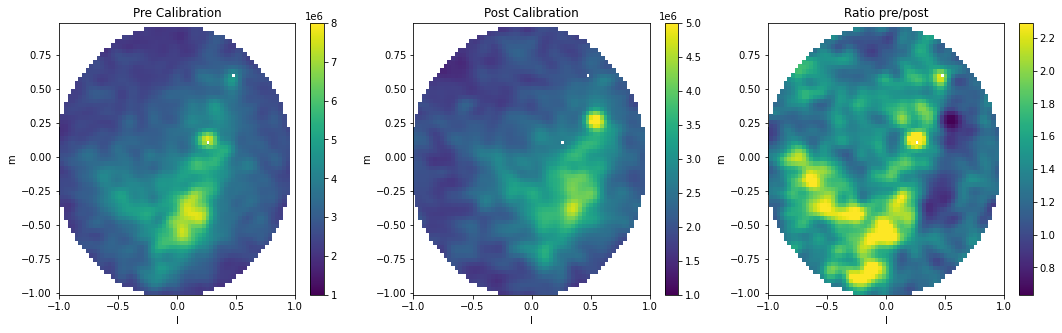

In [491]:
fig, ax = plt.subplots(ncols=3, figsize=(18,5), facecolor="white")


masked_pre = numpy.ma.masked_where(mask, image_pre[0,0,0].real)
masked_post = numpy.ma.masked_where(mask, image_post[0,0,0].real)
ratio = masked_pre/masked_post
masked_pre.mask[image_inds[:, 0], image_inds[:,1]] = numpy.inf
masked_post.mask[image_inds[:, 0], image_inds[:,1]] = numpy.inf
# masked_post.mask[37, 24] = numpy.inf
# masked_pre.mask[16, 12] = numpy.inf
# norm = LogNorm(vmax=1e7, vmin=1e-1)
norm1 = Normalize(vmin=1e6, vmax=8e6)
norm2 = Normalize(vmin=1e6, vmax=5e6)
norm3 = Normalize(
    vmin=ratio.mean() - 2.5 * ratio.std(), 
    vmax=ratio.mean() + 2.5 * ratio.std(),
)
if ones_test:
    norm1 = Normalize(vmin=1e2, vmax=6e6)
    norm2 = Normalize(vmin=1e2, vmax=6e11)
    norm3 = LogNorm(vmin=1e-5, vmax=1e1)


im = ax[0].pcolormesh(l,m, masked_pre, norm=norm1, shading="auto")
fig.colorbar(im, ax=ax[0]);
ax[0].set_title("Pre Calibration");

im = ax[1].pcolormesh(l,m,masked_post, norm=norm2, shading="auto")
fig.colorbar(im, ax=ax[1]);
ax[1].set_title("Post Calibration");

im = ax[2].pcolormesh(l,m,(masked_pre / masked_post), norm=norm3, shading="auto")
fig.colorbar(im, ax=ax[2]);
ax[2].set_title("Ratio pre/post");

for _ax in ax:
    _ax.set_xlabel(r"l")
    _ax.set_ylabel(r"m")
    _ax.set_xlim([-1,1])
    


In [507]:
cal_obj.cal_pixel_inds, cal_obj.cal_pixel_locs, cal_obj.cal_source_locs

(ndarray([[ 4,  9],
          [20, 16]]),
 array([[0.29230769, 0.13846154, 0.94624765],
        [0.50769231, 0.63076923, 0.58683788]]),
 array([[0.27851905, 0.14201126, 0.94987364],
        [0.49280637, 0.62005286, 0.61047222]]))

In [492]:
numpy.unravel_index(masked_pre.argmax(), masked_post.shape), grid_size/2

((19, 37), 32.5)

In [493]:
masked_pre.min()/1e6, masked_pre.max()/1e6

(1.97426525, 7.704195)

In [494]:
masked_post.min()/1e6, masked_post.max()/1e6

(1.424702, 5.4497835)

In [495]:
(~numpy.isfinite(cal_gains[:,:,cal_obj.good_ants])).sum()

0

In [496]:
ratio.mean(), ratio.std()

(1.4620685369318183, 0.3314224484851491)

<ipython-input-497-fabff75bd647>:5: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm1 = SymLogNorm(vmin=-3e8, linthresh=1e6, vmax=2e10)
<ipython-input-497-fabff75bd647>:7: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm2 = SymLogNorm(vmin=-1e5, linthresh=1e5, vmax=5e11)


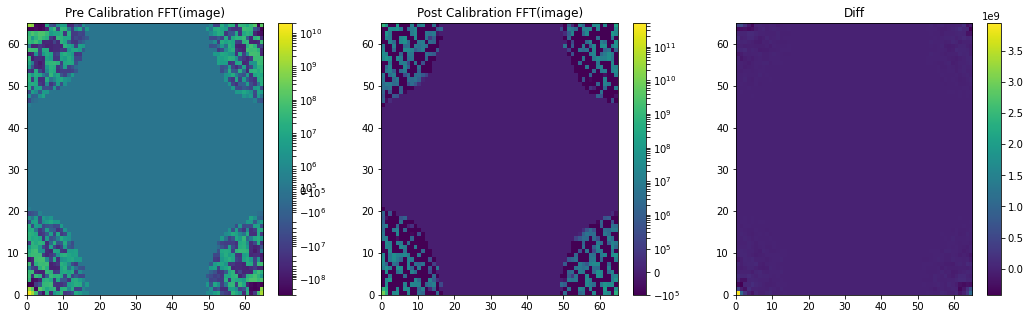

In [497]:
fig, ax = plt.subplots(ncols=3, figsize=(18,5), facecolor="white")

# norm = LogNorm(vmax=1e7, vmin=1e-1)
# norm1 = Normalize(vmin=1e6, vmax=1e9)
norm1 = SymLogNorm(vmin=-3e8, linthresh=1e6, vmax=2e10)
# norm2 = Normalize(vmin=9e5, vmax=2.5e9)
norm2 = SymLogNorm(vmin=-1e5, linthresh=1e5, vmax=5e11)
im = ax[0].pcolorfast(uv_pre[0,0,0].real, norm=norm1)
fig.colorbar(im, ax=ax[0]);
ax[0].set_title("Pre Calibration FFT(image)");

im = ax[1].pcolorfast(uv_post[0,0,0].real, norm=norm2)
fig.colorbar(im, ax=ax[1]);
ax[1].set_title("Post Calibration FFT(image)");

im = ax[2].pcolorfast((uv_pre - uv_post).real[0,0,0])
fig.colorbar(im, ax=ax[2]);
ax[2].set_title("Diff");


In [498]:
uv_pre[0,0,0].real.min()/1e8, uv_pre[0,0,0].real.max()/1e10

(-3.8374559367479306, 1.345781461425)

In [499]:
uv_post[0,0,0].real.min()/1e6, uv_post[0,0,0].real.max()/1e11

(-382.8716404372716, 0.0950755925025)

Text(0.5, 0, 'North/South position [m]')

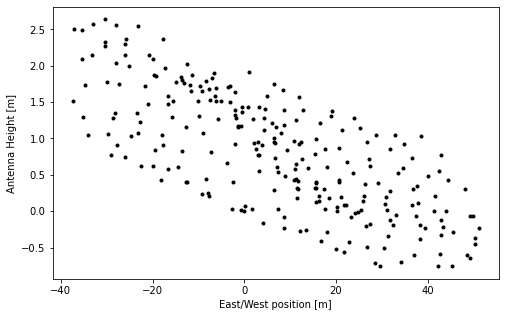

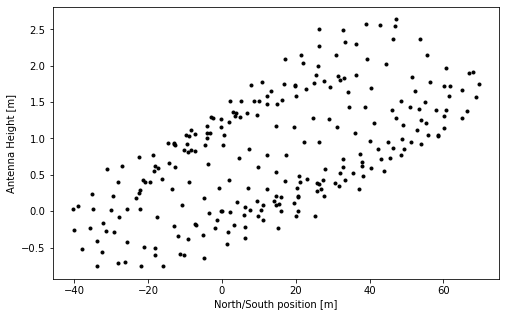

In [500]:
fig, ax = plt.subplots(
    figsize=(8, 5),
    facecolor="white"
)
ax.plot(locations[: ,0 ], locations[:, 2], 'k.');
ax.set_ylabel("Antenna Height [m]")
ax.set_xlabel("East/West position [m]")

fig, ax = plt.subplots(
    figsize=(8, 5),
    facecolor="white"
)
ax.plot(locations[: ,1 ], locations[:, 2], 'k.');
ax.set_ylabel("Antenna Height [m]")
ax.set_xlabel("North/South position [m]")

In [501]:
phases.transpose([1,0,2])[88], cal_obj.get_gains()[88]

(array([[-1.7612559 +0.67927456j, -0.99144745+1.5912879j ],
        [-1.7981918 +0.5763315j , -1.0812914 +1.5323627j ],
        [-1.8291142 +0.47138998j, -1.1676395 +1.468369j  ],
        [-1.8539158 +0.3648009j , -1.2502058 +1.3995132j ]],
       dtype=complex64),
 array([[ 0.        +0.j        , -0.01563266-0.02020708j],
        [ 0.        +0.j        ,  0.0712929 +0.01292835j],
        [ 0.        +0.j        ,  0.06010154+0.11922577j],
        [ 0.        +0.j        ,  0.07738023-0.08210693j]],
       dtype=complex64))

In [502]:
uvws = cal_obj.locations[:, numpy.newaxis, :, :, :] - cal_obj.locations[numpy.newaxis, :, :, :, :]

In [503]:
numpy.max(uvws[:,:,:,:,2],axis=(0,1))

array([[0.58772523, 0.58772523],
       [0.5883003 , 0.5883003 ],
       [0.58887538, 0.58887538],
       [0.58945045, 0.58945045]])

In [504]:
ants0 = numpy.nonzero(numpy.all(cal_obj.temp_gains ==0, axis=(1,2)))[0]

In [505]:
set(ants0) - set(bad_ants)

set()